In [ ]:
import numpy as np
import pickle as p
import mdtraj as md
import h5py as h
import torch
import os

from matplotlib import pyplot as plt
from glob import glob as g
from pprint import pprint as pp
from tqdm import tqdm
from sklearn.manifold import TSNE

if "analysis" in os.getcwd():
    os.chdir("..")
import cvae
hdf = h.File("./data/cov_cmaps_hdf.h5")
models = g("../cvae_30/models/*/*.pickle")
pp(models)

In [53]:
model = models[1]
with open(model,"rb") as f:
    nn = p.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn = nn.to(device)
pp(nn)
def strip(traj):                                                                                                                                                                      
    for res in traj.top.residues:                                                                                                                                                         
        if res.name == "ALA":                                                                                                                                                             
            zero_idx = res.index                                                                                                                                                                                                                                                                                                                       
            break                                                                                                                                                                         
    res_range = range(zero_idx,zero_idx+595)                                                                                                                                              
    atoms = []                                                                                                                                                                            
    for i in res_range:                                                                                                                                                                   
        for atom in traj.top._residues[i].atoms:                                                                                                                                          
            atoms.append(atom.index)                                                                                                                                                      
    return traj.atom_slice(atoms)

def get_res_names(traj):
    def res_name(res):
        return f"{res.name}-{res.resSeq}"
    return [res_name(r) for r in traj.top.residues]

def pool_arr(arr,pool_size=17,cutoff=0.0,preapply=0.8):             
    shape = arr.shape
    if preapply:
        arr = arr < preapply
    try:                    
        assert shape[0] == shape[1]          
        shape = shape[0]                  
    except AssertionError:
        print("Only works for square arrays")
        raise NotImplementedError
    if shape % pool_size != 0:
        print("Please change pool_size\n"
              "None Integer division error")
        raise ArithmeticError
    iters = int(shape/pool_size)
    pooled = np.empty((iters,iters))
    for i in range(iters):
        ilow = i*pool_size
        ihgh = (i+1)*pool_size
        for j in range(iters):
            jlow = j*pool_size
            jhgh = (j+1)*pool_size
            cur_arr = arr[ilow:ihgh,jlow:jhgh]
            pooled[i,j] = 1 if np.average(cur_arr) > cutoff else 0
    return pooled

pdb_ref = "./analysis/ref.pdb"
ref = strip(md.load(pdb_ref))
res_names = get_pooled_atom_names(ref)
res_names[1] = res_names[1].replace("CY1","CYS")
ref.n_residues

cVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(100, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (flat_layer): Flatten(start_dim=1, end_dim=-1)
  (mean): Linear(in_features=169, out_features=3, bias=True)
  (logvar): Linear(in_features=169, out_features=3, bias=True)
  (fc): Linear(in_features=3, out_features=169, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(100, 100, kernel_size

595

In [54]:
a = [*hdf["data"].keys()]
a = a[0]
cmap = hdf["data"][a][0]
cmap.shape

(595, 595)

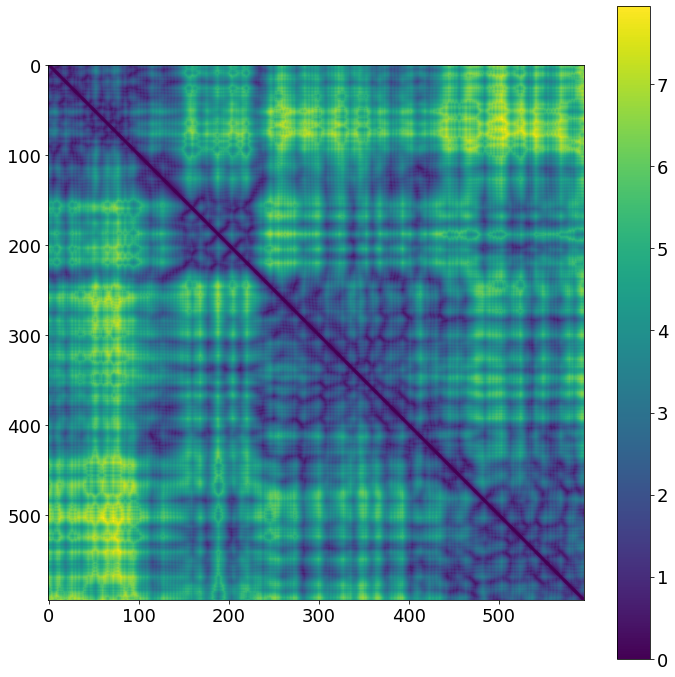

In [55]:
plt.figure(figsize=(12,12))
plt.imshow(cmap)
plt.colorbar()

In [ ]:
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 18})
plt.imshow(np.flip(cmap < .8,axis=1))
plt.colorbar()
xt = plt.xticks([35*i for i in range(17)],res_names[::35],rotation=90)
yt = plt.yticks([(595-35*i)-1 for i in range(17)],(res_names[::35]))

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow( np.flip(pool_arr(cmap),axis=1))
plt.colorbar()
xt = plt.xticks([i-0.5 for i in range(35)][::2],res_names[::17][::2],rotation=90)
yt = plt.yticks([(34.5-i) for i in range(35)][::2],(res_names[::17][::2]))
range(*map(int,plt.xlim()),1)

In [ ]:
for model in models:
    img_dir = f"./images/{model.split('/')[-2]}/"
    print(img_dir)
    if not os.path.isdir(img_dir):
        os.makedirs(img_dir)
    else:
        continue
    with open(model,"rb") as f:
        nn = p.load(f)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn = nn.to(device)
    with open("../cvae_noKLD/models/kld_coeff_0.5/test_data.p","rb") as f:
        test = p.load(f)
    test_data = test[0]
    test_indices = test[1]
    test_labels = hdf["misc/all_labels"][test_indices]
    uniques, counts = np.unique(test_labels,return_counts=True)
    labels = {label: None for label in hdf["data"].keys()}
    new_data = []
    prev = 0
    new_data_dict = {}
    for key in uniques:
        labels[key] = [i for i,x in enumerate(test_labels) if x == key][:500]
        new_data_dict.setdefault(key,[])
        for i,x in enumerate(labels[key]):
            new_data.append(test_data[x])
            new_data_dict[key].append(prev + i)
            
        prev += len(labels[key])
            
    test_data = np.stack(new_data).reshape(-1,35,35)
    print(test_data.shape)
    embed = []
    device = torch.device("cuda")
    print("embedding...")
    for x in tqdm(test_data):
        with torch.no_grad():
#             x = x.detach().view(1,1,35,35).float().to(device)
            x = torch.tensor(x).detach().view(1,1,35,35).float().to(device)
            x = np.array(nn(x)[-1].cpu())
            embed.append(x)
    embed = np.array(embed).reshape(-1,3)
    for perp in tqdm(range(5,80,5)):
        fp = f"{img_dir}perp_{perp}.png"
        print(f"TSNE for perp = {perp}\n File Path = {fp}")
        tsne_test = TSNE(perplexity=perp, early_exaggeration=12.0, learning_rate=200.0,n_iter=5000)
        trans_test = tsne_test.fit_transform(embed)
        plt.figure(figsize=(12,12))
        to_plot = {"ATP":[],"APO":[]}
        for key,indexes in new_data_dict.items():
            if indexes:
                if isinstance(key,bytes):
                    key = key.decode("UTF-8")
                if "ATP" in key:
                    to_plot["ATP"].append(trans_test[indexes])
                if "APO" in key:
                    to_plot["APO"].append(trans_test[indexes])
        to_plot["ATP"] = to_plot["ATP"][:len(to_plot["APO"])]
        for key,v in to_plot.items():
            v = np.vstack(v)
            plt.scatter(v[:,0],v[:,1],label=key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(fp)

In [ ]:
to_plot = {"ATP":[],"APO":[]}
for key,indexes in labels.items():
    if indexes:
        if isinstance(key,bytes):
            key = key.decode("UTF-8")
        if "ATP" in key:
            to_plot["ATP"].append(trans_test[indexes])
        if "APO" in key:
            to_plot["APO"].append(trans_test[indexes])

In [ ]:
analyse = {"ATP":[],"APO":[]}
for key,indexes in new_data_dict.items():
    if indexes:
        if isinstance(key,bytes):
            key = key.decode("UTF-8")
        if "ATP" in key:
            analyse["ATP"].append(test_data[indexes].reshape(-1,35*35))
        if "APO" in key:
            analyse["APO"].append(test_data[indexes].reshape(-1,35*35))
for k in analyse.keys():
    print(k)
    analyse[k] = np.vstack(analyse[k])
    print(analyse[k].shape)

In [ ]:
ATP = analyse["ATP"]
APO = analyse["APO"]
fig,axs = plt.subplots(2,3,figsize=(12,12))
axs[0,0].imshow(ATP[500].reshape(35,35))
axs[0,1].imshow(ATP[1000].reshape(35,35))
axs[0,2].imshow(ATP[2000].reshape(35,35))
axs[1,0].imshow(nn(torch.tensor(ATP[500].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)
axs[1,1].imshow(nn(torch.tensor(ATP[1000].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)
axs[1,2].imshow(nn(torch.tensor(ATP[2000].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)

In [ ]:
APO = analyse["APO"]
fig,axs = plt.subplots(2,3,figsize=(12,12))
axs[0,0].imshow(APO[500].reshape(35,35))
axs[0,1].imshow(APO[1000].reshape(35,35))
axs[0,2].imshow(APO[2000].reshape(35,35))
axs[1,0].imshow(nn(torch.tensor(APO[500].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)
axs[1,1].imshow(nn(torch.tensor(APO[1000].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)
axs[1,2].imshow(nn(torch.tensor(APO[2000].reshape(1,1,35,35)).to(device))[0].cpu().detach().view(35,35) > 0.5)

In [ ]:
ATP_strs = np.array(["".join([str(s)[0] for s in cmap]) for cmap in ATP])
uniq_ATP, count_ATP = np.unique(ATP_strs,return_counts=True)

APO_strs = np.array(["".join([str(s)[0] for s in cmap]) for cmap in APO])
uniq_APO, count_APO = np.unique(APO_strs,return_counts=True)

print("Unique ATP cmaps:",len(uniq_ATP))
print("Unique APO cmaps:",len(uniq_APO))
uniq_ALL = set(set(uniq_APO).union(set(uniq_ATP)))
print("Unique cmaps:",len(uniq_ALL))

In [ ]:
ALL = np.vstack((APO,ATP))
avg_ALL = np.mean(ALL,axis=0)
# plt.imshow(avg_ALL.reshape(35,35))
fig,ax = plt.subplots(2,figsize=(12,12))
tst1 = ax[0].imshow(np.sum(APO,axis=0).reshape(35,35))
tst = ax[1].imshow(np.sum(ATP,axis=0).reshape(35,35))
fig.colorbar(tst)
fig.colorbar(tst1,ax=ax[0])

In [ ]:
# embed = []
# device = torch.device("cuda")
# for x in tqdm(test_data):
#     with torch.no_grad():
#         x = torch.tensor(x).view(1,1,35,35).float().to(device).detach()
#         x = np.array(nn(x)[-1].cpu())
#         embed.append(x)
# embed = np.array(embed).reshape(-1,3)
# embed
# for x in labels.keys():
#     print(x,len(labels[x] if labels[x] else ""))
# test_indices
sums_dict  = {}
for i,x in enumerate(test_data):
    sums = np.sum(x)
    sums_dict.setdefault(int(sums),[])
    sums_dict[sums].append(i)
plt.figure(figsize=(12,12))
for key,value in sums_dict.items():
    plt.scatter(trans_test[:,0][value],trans_test[:,1][value],label=key)


In [ ]:
# tsne_test = TSNE(perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0,verbose=1,n_iter=5000)
# trans_test = tsne_test.fit_transform(embed)
plt.figure(figsize=(12,12))
for key,indexes in labels.items():
    if indexes:
        plt.scatter(trans_test[indexes][:,0],trans_test[indexes][:,1],label=key)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
all_data = hdf["pooled_cmaps"][[*hdf["pooled_cmaps"].keys()][0]]
all_data = np.concatenate((all_data[:10000],all_data[-10000:]),axis=0)
embed = []
device = torch.device("cuda")
for x in tqdm(all_data):
    with torch.no_grad():
        x = torch.tensor(x).view(1,1,35,35).float().to(device).detach()
        x = np.array(nn(x)[-1].cpu())
        embed.append(x)
tsne_test = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2,n_iter=1000)
trans_test = tsne_test.fit_transform(np.array(embed).reshape(-1,12))

In [ ]:
# embed = np.array(embed).reshape(-1,12)
# pp(np.mean(embed,axis=0))
embed[0]
embed[-1]
plt.scatter(trans_test[0,0],trans_test[0,1],label="1")
plt.scatter(trans_test[-1,0],trans_test[-1,1],label="-1")
plt.legend()

In [ ]:
plt.scatter(embed[:100,0],embed[:100,1],label="1")
plt.scatter(embed[-100:,0],embed[-100:,1],label="-1")
plt.legend()


In [ ]:
from sklearn.manifold import MDS
mds = MDS(verbose=2)
t_mds = mds.fit_transform(np.array(embed).reshape(-1,12))

In [ ]:
keys = [*z_dict.keys()]
pp([(k,len(z_dict[k])) for k in keys])
keys = [keys[0],keys[5]]

In [ ]:
data = np.vstack([z_dict[k] for k in keys])
data.shape

In [ ]:
[len(z_dict[k]) for k in keys]

In [ ]:
tsne = TSNE(perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0,verbose=1)
trans = tsne.fit_transform(data.reshape(-1,12))
plt.figure(figsize=(12,12))
prev = 0
plt.scatter(trans[:,0][:10000],trans[:,1][:10000],label=keys[0])
plt.scatter(trans[:,0][10000:20000],trans[:,1][10000:20000],label=keys[1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
plt.figure(figsize=(12,12))
prev = 0
plt.scatter(trans[:,0][:10000],trans[:,1][:10000],label=keys[0])
plt.scatter(trans[:,0][10000:20000],trans[:,1][10000:20000],label=keys[1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
hdf

In [ ]:
all_data = hdf["virts/all_data"]
hdf
avg_cmap = np.var(all_data[::100],axis=0)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap)

In [ ]:
all_data = hdf["pooled_cmaps"][[*hdf["pooled_cmaps"].keys()][0]]
avg_cmap = np.var(all_data[:10000],axis=0)
avg_cmap2 = np.var(all_data[-10000:],axis=0)
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap)
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(avg_cmap2)
plt.colorbar()

In [ ]:
nn

In [ ]:
import os
if os.path.isfile("./z_dict.p"):
    with open("z_dict.p","rb") as f:
        z_dict = p.load(f)
else:
    z_dict = {}


with torch.no_grad():
    for dkey,dset in hdf["data"].items():
        if dkey not in z_dict.keys():
            print(f"Working on {dkey}..")
            z_dict.setdefault(dkey,[])
            for x in tqdm(dset):
                x = pool_arr(x)
                x = torch.tensor(x).view(1,1,35,35).float().to(device)
                z = np.array(nn(x)[-1].cpu())
                z_dict[dkey].append(z)
            with open("z_dict.p","wb") as f:
                p.dump(z_dict,f)

In [ ]:
x = [v for v in z_dict.values()]
x = np.vstack(x)
x = x.reshape(-1,10)
tsne = TSNE(perplexity=80.0, early_exaggeration=12.0, learning_rate=200.0,verbose=2)
trans = tsne.fit_transforlm(x)

plt.figure(figsize=(12,12))
prev = 0
for k,v in z_dict.items():
    cur = prev + 1000
    plt.scatter(trans[:,0][prev:cur],trans[:,1][prev:cur],label=k)
    prev += len(v)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
plt.figure(figsize=(12,12))
prev = 0
for k,v in z_dict.items():
    cur = prev + 1000l
    plt.scatter(trans[:,0][prev:cur],trans[:,1][prev:cur],label=k)
    prev += len(v)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
APO_count = 0
ATP_count = 0
for k,ds in hdf["data"].items():
    if "APO" in k:
        APO_count += ds.shape[0]
        print(k)
    elif "ATP" in k:
        ATP_count += ds.shape[0]
        print(k)
print("APO cmaps:", APO_count)
print("ATP cmaps:", ATP_count)